In [11]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import deque
from SnakeEnv import SnakeEnvironment

In [12]:
class Net(nn.Module):

    def __init__(self, learning_rate=0.01):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_size, 12)  
        self.fc2 = nn.Linear(12, 24)
        self.fc3 = nn.Linear(24, action_size)
        self.optim  = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=0)
        return x

    def fit(self, x, y, epochs=1, verbose=False):
        for epoch in range(epochs):
            
            output = self.forward(x)           
            loss = self.loss_fn(output, y)  

            if verbose:
                print('Epoch: ',epoch,' loss: ',loss)
            
            self.optim.zero_grad()  
            loss.backward()        

            self.optim.step()
        
    def predict(self, x):
        return self.forward(x)

In [13]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.dueling_type = 'avg'

        # Hyperparameters
        self.gamma = 0.99    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001
        self.DQN = Net(self.learning_rate)
        self.target_network = Net(self.learning_rate)
        self.target_network.load_state_dict(self.DQN.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        #np.random.seed(0)
        #torch.manual_seed(0)
        #random.seed(30)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            act_values = self.DQN.predict(torch.Tensor(state))
            return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                #Double DQN
                action_for_next_state = self.act(next_state)
                with torch.no_grad():
                    target = (reward + self.gamma * self.target_network.predict(
                        torch.Tensor(next_state))[0][action_for_next_state])
            with torch.no_grad():              
                target_f = self.DQN.predict(torch.Tensor(state)).numpy()
            target_f[0][action] = target
            self.DQN.fit(torch.Tensor(state), torch.Tensor(target_f), epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, PATH):
        self.DQN.load_state_dict(torch.load(PATH))
        self.DQN.eval()
        

    def save(self, PATH):
        torch.save(self.DQN.state_dict(), PATH)

    #Fixed Q targets
    def update_target_weights(self):
        self.target_network.load_state_dict(self.DQN.state_dict())


In [14]:
EPISODES = 1000
DURATION = 400
SS = 20
tau = 100

episode: 0/1000, score: 0, e: 1.0
episode: 1/1000, score: 0, e: 1.0
episode: 2/1000, score: 0, e: 1.0
episode: 3/1000, score: 0, e: 1.0
episode: 4/1000, score: 0, e: 1.0
episode: 5/1000, score: 0, e: 0.99
episode: 6/1000, score: 0, e: 0.98
episode: 7/1000, score: 0, e: 0.97
episode: 8/1000, score: 0, e: 0.96
episode: 9/1000, score: 0, e: 0.95
episode: 10/1000, score: 0, e: 0.94
episode: 11/1000, score: 0, e: 0.93
episode: 12/1000, score: 0, e: 0.92
episode: 13/1000, score: 0, e: 0.91
episode: 14/1000, score: 0, e: 0.9
episode: 15/1000, score: 0, e: 0.89
episode: 16/1000, score: 0, e: 0.88
episode: 17/1000, score: 0, e: 0.87
episode: 18/1000, score: 0, e: 0.86
episode: 19/1000, score: 0, e: 0.85
episode: 20/1000, score: 1, e: 0.84
episode: 21/1000, score: 0, e: 0.83
episode: 22/1000, score: 0, e: 0.83
episode: 23/1000, score: 0, e: 0.82
episode: 24/1000, score: 0, e: 0.81
episode: 25/1000, score: 0, e: 0.8
episode: 26/1000, score: 0, e: 0.79
episode: 27/1000, score: 0, e: 0.79
episode: 

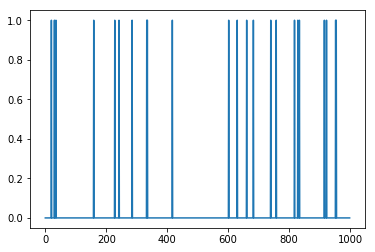

In [15]:
# Initialise environment
render = False
env = SnakeEnvironment(screenSize = SS,render = render)
state_size = len(env.state)
action_size = len(env.actions)
memory = deque(maxlen=2000)
agent = DQNAgent(state_size, action_size)
agent.load("snake-v4-dqn.pt")
batch_size = 50
scores=[]
for e in range(EPISODES):
    env = SnakeEnvironment(screenSize = SS, render=render)
    state = env.state
    state = np.reshape(state, [1, state_size])
    apples_collected = 0
    for time in range(DURATION+1):
        action = agent.act(state)
        next_state, reward, done, apple = env.step(action)
        apples_collected += apple
        next_state = np.reshape(next_state, [1, state_size])
        if time == DURATION:
            reward = -10
        if reward != 0:
            agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done or time == DURATION:
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, EPISODES, apples_collected, agent.epsilon))
            scores.append(env.totalReward)
            break
        if time % tau == 0:
            agent.update_target_weights()

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

    if e % 10 == 0:
        agent.save("snake-v4-dqn.pt")


plt.plot(range(len(scores)),scores)
plt.show()